In [26]:
import pandas as pd
import numpy as np
import urllib.parse
import urllib.request
from tqdm import tqdm
import os
import time
import subprocess
from scipy import stats
import matplotlib.pyplot as plt

def uniprotMapping(query, From="ACC",To="ACC",Format="fasta",Columns="",outputDir=""):
    for i in range(10):
        try:
            url = 'https://www.uniprot.org/uploadlists/'
            params={
                "query":query,
                "from":From,
                "to":To,
                "format":Format,
                "columns":Columns,
            }
            data = urllib.parse.urlencode(params)
            data = data.encode('utf-8')
            req = urllib.request.Request(url, data)
            with urllib.request.urlopen(req) as f:
                response = str(f.read(),encoding="utf-8")
            fileName="{}_{}_{}.{}".format(query.replace("\n",""),From,To,Format)
            outputPath="{}{}".format(outputDir,fileName)
            if outputDir and not os.path.exists(outputDir):
                os.makedirs(outputDir)
            with open(outputPath,"w") as f:
                f.write(response)
            return response
        except:
            print("request failed, wait for", i*5,"seconds and try again")
            time.sleep(i*5)
            
def cdhit(inputFastaFile, identity=0.9, outputDir="",verbose=False):
    if outputDir and not os.path.exists(outputDir):
        os.makedirs(outputDir)
    outputFile=inputFastaFile.split("/")[-1].replace(".fasta","_cdhit{}.fasta".format(identity))
    outputFilePath="{}{}".format(outputDir,outputFile)
    command = "cd-hit -i {} -o {} -c {}  -n 2 -M 1500".format(inputFastaFile,outputFilePath,identity)
    cmd = subprocess.Popen(command,
                           shell=True,
                           stdin=subprocess.PIPE,
                          stdout=subprocess.PIPE,
                          stderr=subprocess.STDOUT)
    if verbose:
        print(cmd.communicate())
    else:
        cmd.communicate()
    return outputFilePath

def clustalo(inputFastaFile,outputDir=""):
    if outputDir and not os.path.exists(outputDir):
        os.makedirs(outputDir)
    outputFile=inputFastaFile.split("/")[-1].replace(".fasta","_MSA.fasta")
    outputFilePath="{}{}".format(outputDir,outputFile)
    command = "clustalo -i {} -o {} --force".format(inputFastaFile,outputFilePath)
    cmd = subprocess.Popen(command,
                           shell=True,
                           stdin=subprocess.PIPE,
                          stdout=subprocess.PIPE,
                          stderr=subprocess.STDOUT)
    cmd.communicate()
    return outputFilePath

def parseFasta(fastaFile):
    f=open(fastaFile)
    fastaStr=f.read()
    f.close()
    lol=[entry.replace("\n","toSplit",1).replace("\n","").split("toSplit")
        for entry
        in fastaStr[1:].split(">")]
    lol=[(entry.split("|")[:2][-1],seq) for entry,seq in lol]
    dic={entry:sequence for entry,sequence in lol}
    return dic

def writeFasta(fastaDic,file,minSize=0):
    f = open(file,"w")
    for key,value in fastaDic.items():
        if minSize>len(value):
            value+="-"*(minSize-len(value))
        f.write(">{}\n{}\n".format(key,value))
    return file

def putFirstInFasta(fastaFile,Id):
    dic = parseFasta(fastaFile)
    fastaOrdered = [(key,seq) for key,seq in dic.items() if key==Id] + [(key,seq) for key,seq in dic.items() if key!=Id]
    toWrite=""
    for key,seq in fastaOrdered:
        toWrite+=">{}\n{}\n".format(key,seq)
    with open(fastaFile,"w") as f:
        f.write(toWrite)
        
def getMsaPeridictions(msaFile, verbose=False):
    OutputFile=msaFile.replace(".fasta","_EFoldMine.pred")
    
    command = "python2 efoldminePredictionsMsa.py {} {}".format(msaFile,OutputFile)
    cmd = subprocess.Popen(command,
                           shell=True,
                           stdin=subprocess.PIPE,
                          stdout=subprocess.PIPE,
                          stderr=subprocess.STDOUT)
    if verbose:
        print(cmd.communicate())
    else:
        cmd.communicate()
    return OutputFile

def msaPredictions2Dic(msaPredictionFile):
    with open(msaPredictionFile) as f:
        msaPredictionString=f.read()
    msaPredictionDic=dict()
    for line in msaPredictionString.split("\n"):
        if line.startswith(">"):
            Id=line.replace(">","")
            msaPredictionDic[Id]=dict()
        else:
            if line:
                feature, featureSequence = line.split("\t")
                if feature=="sequence":
                    msaPredictionDic[Id][feature]=featureSequence.split(" ")
                else:
                    msaPredictionDic[Id][feature]=[float(elm) 
                                                   for elm 
                                                   in featureSequence.split(" ")]
    return msaPredictionDic

def findRelPosInMsa(msaSeq, pos):
        seq = msaSeq
        msaPos=0
        i=0
        while i<=pos:
            msaPos+=1
            if seq[msaPos]!="-":
                i+=1
        return msaPos
    
def cutPredictions(predictionDic,start=None,end=None):
    predictionDicNew=dict()
    for ID in predictionDic.keys():
        predictionDicNew[ID]=dict()
        for feature,seqList in predictionDic[ID].items():
            predictionDicNew[ID][feature]=seqList[start:end]
    return predictionDicNew

def writePredictions2File(predictionDic,fileName):
    with open(fileName,"w") as f:
        for ID in predictionDic.keys():
            f.write(">{}\n".format(ID))
            for feature,seqList in predictionDic[ID].items():
                seqListOfStrings=map(str,seqList)
                seqStr=" ".join(seqListOfStrings)
                f.write("{}\t{}\n".format(feature,seqStr))
    return fileName

def msaPredictionsDic2Arrays(msaPredictionDic):
    Ids =  sorted(msaPredictionDic.keys())
    features = sorted(msaPredictionDic[Ids[0]].keys())
    cols = len(msaPredictionDic[Ids[0]][features[0]])
    rows = len(Ids)
    
    dicOfArrays=dict()
    for feature in features:
        if feature=="sequence":
            dicOfArrays[feature]=np.zeros((rows,cols),dtype=str)
            dicOfArrays[feature][:,:]="-"
        else:
            dicOfArrays[feature]=np.zeros((rows,cols),dtype=float)
            dicOfArrays[feature][:,:]=np.nan
            
    for i,Id in enumerate(Ids):
        for feature in features:
            dicOfArrays[feature][i,:]=msaPredictionDic[Id][feature]
    return dicOfArrays

def wilcoxonRanksumTest(periplasm,cytoplasm,pValue=5e-2,minDataSize=10):
    features = [feature for feature in periplasm.keys() if feature!="sequence"]
    rows, cols = periplasm[features[0]].shape
    
    wilcoxonResults=dict()
    
    for feature in features:
        wilcoxonResults[feature]=list()
        for i in range(cols):
            cytoData=[value for value in cytoplasm[feature][:,i] if not np.isnan(value)]
            periData=[value for value in periplasm[feature][:,i] if not np.isnan(value)]
            if len(cytoData)<minDataSize or len(periData)<minDataSize:
                wilcoxonResults[feature].append(float("nan"))
            else:
                statistic, pValue_observed = stats.ranksums(cytoData,periData)
                if pValue_observed > pValue:
                    wilcoxonResults[feature].append(0)
                else:
                    wilcoxonResults[feature].append(statistic)
    return wilcoxonResults

def getMedian(wilcoxonResults):
    arrays=dict()
    ids = sorted(wilcoxonResults.keys())
    features= sorted(wilcoxonResults[ids[0]])
    longest = max(map(len, [wilcoxonResults[Id][features[0]] for Id in ids]))
    for feature in features:
        arrays[feature]=np.zeros((len(ids),longest))
        arrays[feature][:,:]=np.nan
    for i,Id in enumerate(ids):
        for feature in features:
            values = wilcoxonResults[Id][feature]
            arrays[feature][i,:len(values)]=values
    medians=dict()
    for i,Id in enumerate(ids):
        for feature in features:
            medians[feature]=np.nanmedian(arrays[feature],axis=0)
    return medians

def getPercentile(wilcoxonResults, percentile=25):
    arrays=dict()
    ids = sorted(wilcoxonResults.keys())
    features= sorted(wilcoxonResults[ids[0]])
    longest = max(map(len, [wilcoxonResults[Id][features[0]] for Id in ids]))
    for feature in features:
        arrays[feature]=np.zeros((len(ids),longest))
        arrays[feature][:,:]=np.nan
    for i,Id in enumerate(ids):
        for feature in features:
            values = wilcoxonResults[Id][feature]
            arrays[feature][i,:len(values)]=values
    Percentile=dict()
    for i,Id in enumerate(ids):
        for feature in features:
            Percentile[feature]=np.nanpercentile(arrays[feature],percentile,axis=0)
    return Percentile

def parseClstr(clstrFile):
    clstrDic=dict()
    F = open(clstrFile)
    for LINE in F:
        LINE = LINE.replace("\n","")
        if LINE.startswith(">"):
            ID=LINE.replace(">","")
            clstrDic[ID]=list()
        else:
            member = LINE.split(">")[-1].split(".")[0]
            clstrDic[ID].append(member)
    return clstrDic

def writeWilcoxonResults(file,wilcoxonResults,cyto_id, peri_id):
    f=open(file,"a")
    f.write(">{}|{}\n".format(cyto_id, peri_id))
    for feature,sequence in wilcoxonResults.items():
        sequenceString=" ".join([str(elm) for elm in sequence])
        f.write("{}\t{}\n".format(feature,sequenceString))
    f.close()

TWINS = pd.read_csv("../2020-05-12.wilcoxon-ranksum-test/twins_info.tab",sep="\t",index_col=0).reset_index(drop=True)
TWINS

,Cytoplasm,Periplasm,Organism,SP_start,SP_end,Cytoplasm_uniref50,Cytoplasm_uniref50_size,Periplasm_uniref50,Periplasm_uniref50_size,Cytoplasm_length,Periplasm_length,length_ratio,length_abs_diff
0,A0A169XQ31,A0A2I8WC74,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
1,A0A169XQ31,A0A0G3S663,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
2,A0A169XQ31,A0A3E1SVQ6,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
3,A0A169XQ31,A0A384I9X6,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
4,A0A169XQ31,A0A168N292,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27634,A0A2V9DP80,A0A3N5ZMI4,Acidobacteria_bacterium,1,19,UniRef50_A0A317I3X7,20,UniRef50_A0A3N5ZMI4,1,1161,349,0.285099,830
27635,A0A2V9QGT4,A0A3N5ZMI4,Acidobacteria_bacterium,1,19,UniRef50_A0A522PXJ5,10,UniRef50_A0A3N5ZMI4,1,1177,349,0.281223,846
27636,A0A522PXJ5,A0A3N5ZMI4,Acidobacteria_bacterium,1,19,UniRef50_A0A522PXJ5,10,UniRef50_A0A3N5ZMI4,1,1179,349,0.280746,848
27637,A0A522PXJ5,A0A3N5ZMI4,Acidobacteria_bacterium,1,19,UniRef50_A0A522PXJ5,10,UniRef50_A0A3N5ZMI4,1,1179,349,0.280746,848


In [2]:
"""Get Info of all the Twins"""
TWINS = pd.read_csv("../2020-05-12.wilcoxon-ranksum-test/twins_info.tab",sep="\t",index_col=0).reset_index(drop=True)

"""Keep Twins with two different Uniref50 groups"""
TWINS = TWINS[TWINS["Cytoplasm_uniref50"]!=TWINS["Periplasm_uniref50"]].reset_index(drop=True).reset_index(drop=True)

"""Keep Twins with length ratio > ratio_thr"""
ratio_thr=0.75
TWINS = TWINS[TWINS["length_ratio"]>ratio_thr].reset_index(drop=True)

"""Keep Twins abs diff<abs_thr"""
#abs_thr=50
#TWINS = TWINS[TWINS["length_abs_diff"]<abs_thr].reset_index(drop=True)

"""Reduce to unique groups"""
print("Unique cytoplasm uniref50 groups:", len(TWINS["Cytoplasm_uniref50"].unique()))
print("Unique periplasm uniref50 groups:", len(TWINS["Periplasm_uniref50"].unique()))
#TWINS.sort_values("length_ratio",ascending=False).groupby(["Cytoplasm_uniref50","Periplasm_uniref50"],as_index=True).first()
TWINS=TWINS.sort_values(["Periplasm_uniref50_size"],ascending=False).groupby("Cytoplasm_uniref50",as_index=False).first()
TWINS=TWINS.sort_values(["Cytoplasm_uniref50_size"],ascending=False).groupby("Periplasm_uniref50",as_index=False).first()
TWINS

Unique cytoplasm uniref50 groups: 20
Unique periplasm uniref50 groups: 21


,Periplasm_uniref50,Cytoplasm_uniref50,Cytoplasm,Periplasm,Organism,SP_start,SP_end,Cytoplasm_uniref50_size,Periplasm_uniref50_size,Cytoplasm_length,Periplasm_length,length_ratio,length_abs_diff
0,UniRef50_A0A1X1D1X1,UniRef50_Q2NVU4,A0A484WTL8,A0A0A3ZPT1,Enterobacter_cancerogenus,1,35,124,148,171,166,0.771930,39
1,UniRef50_O53021,UniRef50_P83221,P23869,P0AFL3,Escherichia_coli_strain_K12,1,24,4189,2118,164,190,0.982036,3
2,UniRef50_O59651,UniRef50_Q96VT4,Q9ZGM4,Q9WXB9,Legionella_pneumophila,1,27,1678,9906,721,749,0.997234,2
3,UniRef50_P00805,UniRef50_P0A963,P0A962,P00805,Escherichia_coli_strain_K12,1,22,3836,2537,338,348,0.967456,11
4,UniRef50_P0AAL4,UniRef50_P0AAL2,A0A3T8GC16,P0AAL5,Shigella_flexneri,1,41,1270,492,164,231,0.858639,27
5,UniRef50_P0C278,UniRef50_P10902,Q8EH88,P83223,Shewanella_oneidensis_strain_MR-1,1,25,6730,160,537,596,0.938811,35
6,UniRef50_P25718,UniRef50_P21517,P21517,P25718,Escherichia_coli_strain_K12,1,17,4496,5447,604,676,0.915152,56
7,UniRef50_P39185,UniRef50_O33732,O33732,Q080C0,Shewanella_frigidimarina_strain_NCIMB_400,1,27,29,6749,938,829,0.856077,135
8,UniRef50_P44652,UniRef50_P44650,P44650,P44652,Haemophilus_influenzae_strain_ATCC_51907__DSM_...,1,50,243,304,176,279,0.765217,54
9,UniRef50_P45523,UniRef50_P0A9L3,P0A9L3,P45523,Escherichia_coli_strain_K12,1,25,1427,2225,206,270,0.837398,40


In [3]:
# These should either be removed or have some additional tests to distinguish periplasm from cytoplasm
set(TWINS["Periplasm_uniref50"].unique())&set(TWINS["Cytoplasm_uniref50"].unique())

{'UniRef50_Q32JZ5', 'UniRef50_Q8ZRT8'}

In [4]:
"""
Not all protein Ids map to themselve, so first it is necessary to map to the protein id itself
"""
for INDEX, ROW in TWINS.iterrows():
    print()
    CYTO_ID = ROW["Cytoplasm"]
    PERI_ID = ROW["Periplasm"]
    TWIN_DIR = "{}_{}/".format(CYTO_ID,PERI_ID)
    print("Download uniref ID of cytoplasmic protein", CYTO_ID)
    print("\t",uniprotMapping(CYTO_ID, From="ACC", To="ACC", Format="list", outputDir="{}{}".format(TWIN_DIR,"Cytoplasm/")))
    print("Download uniref ID of periplasmic protein", PERI_ID)
    print("\t",uniprotMapping(PERI_ID, From="ACC", To="ACC", Format="list", outputDir="{}{}".format(TWIN_DIR,"Periplasm/")))


Download uniref ID of cytoplasmic protein A0A484WTL8
	 A0A484WTL8

Download uniref ID of periplasmic protein A0A0A3ZPT1
	 A0A0A3ZPT1


Download uniref ID of cytoplasmic protein P23869
	 P23869

Download uniref ID of periplasmic protein P0AFL3
	 P0AFL3


Download uniref ID of cytoplasmic protein Q9ZGM4
	 Q9ZGM4

Download uniref ID of periplasmic protein Q9WXB9
	 Q9WXB9


Download uniref ID of cytoplasmic protein P0A962
	 P0A962

Download uniref ID of periplasmic protein P00805
	 P00805


Download uniref ID of cytoplasmic protein A0A3T8GC16
	 A0A3T8GC16

Download uniref ID of periplasmic protein P0AAL5
	 P0AAL5


Download uniref ID of cytoplasmic protein Q8EH88
	 Q8EH88

Download uniref ID of periplasmic protein P83223
	 P83223


Download uniref ID of cytoplasmic protein P21517
	 P21517

Download uniref ID of periplasmic protein P25718
	 P25718


Download uniref ID of cytoplasmic protein O33732
	 O33732

Download uniref ID of periplasmic protein Q080C0
	 Q080C0


Download uniref ID of c

In [5]:
"""
Look at Uniprot Ids and download uniref50 Ids for both Cytoplasmic and periplasmic proteins.
"""
for DIR in [D for D in os.listdir("./") if D.count(".")==0 and D.count("b2bTools")==0]:
    print()
    for SUBDIR in [D for D in os.listdir(DIR) if D.count(".")==0]:
        SUBDIR_PATH="{}/{}/".format(DIR,SUBDIR)
        for FILE in [F for F in os.listdir(SUBDIR_PATH) if F.count("_ACC_ACC.list")>0]:
            FILE_PATH="{}{}".format(SUBDIR_PATH,FILE)
            with open(FILE_PATH) as F:
                QUERY=F.read()
            print("Download uniref50 group Id of", QUERY.replace("\n",""))
            RESPONSE=uniprotMapping(QUERY, From="ACC", To="NF50", Format="list",outputDir=SUBDIR_PATH)
            print(RESPONSE)


Download uniref50 group Id of P00805
UniRef50_P00805

Download uniref50 group Id of P0A962
UniRef50_P0A963


Download uniref50 group Id of A0A2K3TM34
UniRef50_Q8XDH7

Download uniref50 group Id of A0A368ING8
UniRef50_P62602


Download uniref50 group Id of Q080C0
UniRef50_P39185

Download uniref50 group Id of O33732
UniRef50_O33732


Download uniref50 group Id of A0A1X1M0G1
UniRef50_Q8ZRT8

Download uniref50 group Id of A0A237NMK1
UniRef50_Q32JZ5


Download uniref50 group Id of P0AFL3
UniRef50_O53021

Download uniref50 group Id of P23869
UniRef50_P83221


Download uniref50 group Id of A0A3W3WI41
UniRef50_Q32JZ5

Download uniref50 group Id of W9BJ44
UniRef50_Q8ZRT8


Download uniref50 group Id of Q72EC8
UniRef50_Q72EC8

Download uniref50 group Id of Q72CB8
UniRef50_Q72CB8


Download uniref50 group Id of P0AAL5
UniRef50_P0AAL4

Download uniref50 group Id of A0A3T8GC16
UniRef50_P0AAL2


Download uniref50 group Id of A0A0A3ZPT1
UniRef50_A0A1X1D1X1

Download uniref50 group Id of A0A484WTL8


In [6]:
"""Use the UniRef50 groups to retrieve members
Also retrieve signal peptide information if available"""
for DIR in [D for D in os.listdir("./") if D.count(".")==0 and D.count("b2bTools")==0]:
    print()
    for SUBDIR in [D for D in os.listdir(DIR) if D.count(".")==0]:
        SUBDIR_PATH="{}/{}/".format(DIR,SUBDIR)
        for FILE in [F for F in os.listdir(SUBDIR_PATH) if F.count("_ACC_NF50.list")>0]:
            FILE_PATH="{}{}".format(SUBDIR_PATH,FILE)
            with open(FILE_PATH) as F:
                QUERY=F.read()
            print("Getting members of group", QUERY.replace("\n",""))
            RESPONSE=uniprotMapping(QUERY, From="NF50", To="ACC", Format="tab",Columns="id,sequence,feature(SIGNAL)",outputDir=SUBDIR_PATH)
            print("\t",RESPONSE.count("\n"), "members")


Getting members of group UniRef50_P00805
	 1575 members
Getting members of group UniRef50_P0A963
	 2463 members

Getting members of group UniRef50_Q8XDH7
	 1685 members
Getting members of group UniRef50_P62602
	 1190 members

Getting members of group UniRef50_P39185
	 3502 members
Getting members of group UniRef50_O33732
	 13 members

Getting members of group UniRef50_Q8ZRT8
	 789 members
Getting members of group UniRef50_Q32JZ5
	 434 members

Getting members of group UniRef50_O53021
	 1467 members
Getting members of group UniRef50_P83221
	 3220 members

Getting members of group UniRef50_Q32JZ5
	 434 members
Getting members of group UniRef50_Q8ZRT8
	 789 members

Getting members of group UniRef50_Q72EC8
	 13 members
Getting members of group UniRef50_Q72CB8
	 19 members

Getting members of group UniRef50_P0AAL4
	 309 members
Getting members of group UniRef50_P0AAL2
	 917 members

Getting members of group UniRef50_A0A1X1D1X1
	 59 members
Getting members of group UniRef50_Q2NVU4
	 67 mem

In [3]:
"""Extract signal peptides from tab file"""
for DIR in [D for D in os.listdir("./") if D.count(".")==0 and D.count("b2bTools")==0]:
    print()
    FILE = [F for F in os.listdir(DIR+"/Periplasm") if F.count("NF50_ACC.tab")>0][0]
    FILE_PATH="{}/{}/{}".format(DIR,"Periplasm",FILE)
    print("Extracting Signal peptides from",FILE)
    F = open(FILE_PATH)
    OUTPUT=FILE_PATH.replace(".tab","_SP.fasta")
    O = open(OUTPUT,"w")
    F.readline()
    for LINE in F:
        LINE_SPLIT=LINE.strip().split("\t")
        if len(LINE_SPLIT)==4:
            ID,SEQ,SP_RAW,NF50 = LINE_SPLIT
            START_WITHOUT_SP_STR=SP_RAW.split(";")[0].replace("SIGNAL ","").split("..")[-1]
            if START_WITHOUT_SP_STR:
                START_WITHOUT_SP = int(START_WITHOUT_SP_STR)
                O.write(">{}\n{}\n".format(ID,SEQ[:START_WITHOUT_SP]))
    F.close()
    O.close()
    with open(OUTPUT) as F:
        OUTPUT_LEN=F.read().count(">")
    print("\t (",OUTPUT_LEN," Signal peptides)")


Extracting Signal peptides from UniRef50_P00805_NF50_ACC.tab
	 ( 1238  Signal peptides)

Extracting Signal peptides from UniRef50_Q8XDH7_NF50_ACC.tab
	 ( 1331  Signal peptides)

Extracting Signal peptides from UniRef50_P39185_NF50_ACC.tab
	 ( 2350  Signal peptides)

Extracting Signal peptides from UniRef50_Q8ZRT8_NF50_ACC.tab
	 ( 18  Signal peptides)

Extracting Signal peptides from UniRef50_O53021_NF50_ACC.tab
	 ( 1316  Signal peptides)

Extracting Signal peptides from UniRef50_Q32JZ5_NF50_ACC.tab
	 ( 166  Signal peptides)

Extracting Signal peptides from UniRef50_Q72EC8_NF50_ACC.tab
	 ( 8  Signal peptides)

Extracting Signal peptides from UniRef50_P0AAL4_NF50_ACC.tab
	 ( 3  Signal peptides)

Extracting Signal peptides from UniRef50_A0A1X1D1X1_NF50_ACC.tab
	 ( 10  Signal peptides)

Extracting Signal peptides from UniRef50_O59651_NF50_ACC.tab
	 ( 503  Signal peptides)

Extracting Signal peptides from UniRef50_P0C278_NF50_ACC.tab
	 ( 80  Signal peptides)

Extracting Signal peptides fro

In [5]:
IDENTITY_MIN=0.9
IDENTITY_MAX=0.5

In [6]:
"""Cluster signal peptides with CDHIT"""
TOTAL_CLUSTERS=0
for DIR in [D for D in os.listdir("./") if D.count(".")==0 and D.count("b2bTools")==0]:
    print()
    FILE = [F for F in os.listdir(DIR+"/Periplasm") if F.count("NF50_ACC_SP.fasta")>0][0]
    FILE_PATH="{}/{}/{}".format(DIR,"Periplasm",FILE)
    print("Clustering Signal peptides of",FILE,":max SI=",IDENTITY_MAX)
    OUTPUT = cdhit(FILE_PATH, identity=IDENTITY_MIN, outputDir=DIR+"/Periplasm/",verbose=False)
    OUTPUT2 = cdhit(OUTPUT, identity=IDENTITY_MAX, outputDir=DIR+"/Periplasm/",verbose=False)
    print(OUTPUT)
    with open(FILE_PATH) as F:
        INPUT_LEN=F.read().count(">")
    with open(OUTPUT) as F:
        OUTPUT_LEN=F.read().count(">")
    with open(OUTPUT2) as F:
        OUTPUT2_LEN=F.read().count(">")
        TOTAL_CLUSTERS+=OUTPUT2_LEN
    print("\t{}-->{}-->{}".format(INPUT_LEN,OUTPUT_LEN,OUTPUT2_LEN))
print("\n",TOTAL_CLUSTERS,"clusters were generated in total")


Clustering Signal peptides of UniRef50_P00805_NF50_ACC_SP.fasta :max SI= 0.5
P0A962_P00805/Periplasm/UniRef50_P00805_NF50_ACC_SP_cdhit0.9.fasta
	1238-->132-->33

Clustering Signal peptides of UniRef50_Q8XDH7_NF50_ACC_SP.fasta :max SI= 0.5
A0A368ING8_A0A2K3TM34/Periplasm/UniRef50_Q8XDH7_NF50_ACC_SP_cdhit0.9.fasta
	1331-->118-->25

Clustering Signal peptides of UniRef50_P39185_NF50_ACC_SP.fasta :max SI= 0.5
O33732_Q080C0/Periplasm/UniRef50_P39185_NF50_ACC_SP_cdhit0.9.fasta
	2350-->418-->8

Clustering Signal peptides of UniRef50_Q8ZRT8_NF50_ACC_SP.fasta :max SI= 0.5
A0A237NMK1_A0A1X1M0G1/Periplasm/UniRef50_Q8ZRT8_NF50_ACC_SP_cdhit0.9.fasta
	18-->3-->1

Clustering Signal peptides of UniRef50_O53021_NF50_ACC_SP.fasta :max SI= 0.5
P23869_P0AFL3/Periplasm/UniRef50_O53021_NF50_ACC_SP_cdhit0.9.fasta
	1316-->124-->12

Clustering Signal peptides of UniRef50_Q32JZ5_NF50_ACC_SP.fasta :max SI= 0.5
A0A4V0HDT9_A0A3W3WI41/Periplasm/UniRef50_Q32JZ5_NF50_ACC_SP_cdhit0.9.fasta
	166-->12-->1

Clustering S

In [7]:
""" Put all the signal peptides in one file"""

FILE_OUTPUT="SP_all.fasta"
print("Combining Signal Peptide sequences in single file:",FILE_OUTPUT)
O = open(FILE_OUTPUT,"w")
for DIR in [D for D in os.listdir("./") if D.count(".")==0 and D.count("b2bTools")==0]:
    FILE = [F for F in os.listdir(DIR+"/Periplasm") if F.count("NF50_ACC_SP.fasta")>0][0]
    FILE_PATH="{}/{}/{}".format(DIR,"Periplasm",FILE)
    with open(FILE_PATH) as F:
        INPUT=F.read()
        INPUT_LEN=INPUT.count(">")
        print("\tAdding",INPUT_LEN,"singal peptides from",FILE)
        O.write(INPUT)
O.close()
with open(FILE_OUTPUT) as O:
    TOTAL=O.read().count(">")
    print(TOTAL,"signal peptides in total")

Combining Signal Peptide sequences in single file: SP_all.fasta
	Adding 1238 singal peptides from UniRef50_P00805_NF50_ACC_SP.fasta
	Adding 1331 singal peptides from UniRef50_Q8XDH7_NF50_ACC_SP.fasta
	Adding 2350 singal peptides from UniRef50_P39185_NF50_ACC_SP.fasta
	Adding 18 singal peptides from UniRef50_Q8ZRT8_NF50_ACC_SP.fasta
	Adding 1316 singal peptides from UniRef50_O53021_NF50_ACC_SP.fasta
	Adding 166 singal peptides from UniRef50_Q32JZ5_NF50_ACC_SP.fasta
	Adding 8 singal peptides from UniRef50_Q72EC8_NF50_ACC_SP.fasta
	Adding 3 singal peptides from UniRef50_P0AAL4_NF50_ACC_SP.fasta
	Adding 10 singal peptides from UniRef50_A0A1X1D1X1_NF50_ACC_SP.fasta
	Adding 503 singal peptides from UniRef50_O59651_NF50_ACC_SP.fasta
	Adding 80 singal peptides from UniRef50_P0C278_NF50_ACC_SP.fasta
	Adding 1225 singal peptides from UniRef50_P45523_NF50_ACC_SP.fasta
	Adding 1634 singal peptides from UniRef50_P25718_NF50_ACC_SP.fasta
	Adding 53 singal peptides from UniRef50_Q7M827_NF50_ACC_SP.fa

[15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38
 40 41 42 43 44 45 46 47 50]


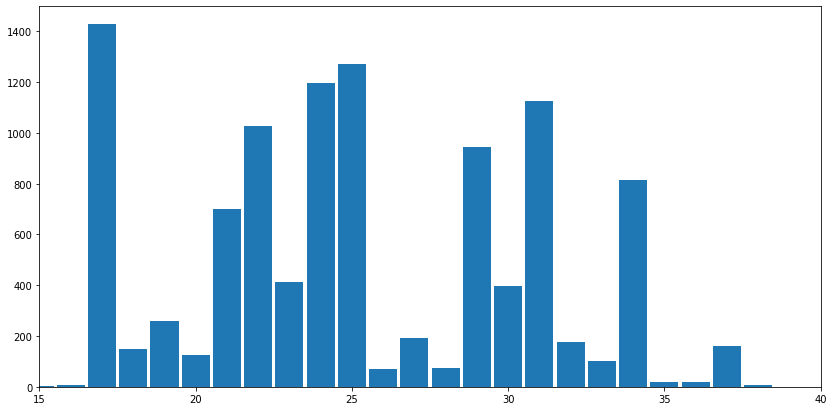

Generating fasta for signal peptides of length 20
	126 signal peptides
Generating fasta for signal peptides of length 21
	699 signal peptides
Generating fasta for signal peptides of length 22
	1026 signal peptides
Generating fasta for signal peptides of length 23
	414 signal peptides
Generating fasta for signal peptides of length 24
	1196 signal peptides
Generating fasta for signal peptides of length 25
	1270 signal peptides
Generating fasta for signal peptides of length 26
	70 signal peptides
Generating fasta for signal peptides of length 27
	192 signal peptides
Generating fasta for signal peptides of length 28
	75 signal peptides
Generating fasta for signal peptides of length 29
	946 signal peptides
Generating fasta for signal peptides of length 30
	395 signal peptides
Generating fasta for signal peptides of length 31
	1127 signal peptides
Generating fasta for signal peptides of length 32
	175 signal peptides
Generating fasta for signal peptides of length 33
	100 signal peptides
Gene

In [68]:
""" Plot the length distribution of signal peptides """
FILE="SP_all.fasta"
FASTA_DIC=parseFasta(FILE)
SP_LENGTHS = list(map(len,FASTA_DIC.values()))
SP_UNIQUE_LENGTHS=np.unique(SP_LENGTHS)
print(SP_UNIQUE_LENGTHS)

plt.figure(figsize=(14,7))
plt.hist(SP_LENGTHS,bins=np.arange(-0.5,40.5,1),rwidth=0.9)
plt.xlim((15,40))
plt.show()

""" Split signal peptides by length """
OUTPUT_DIR="spByLength"
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

for SIZE in [S for S in SP_UNIQUE_LENGTHS if S>=20]:
    FASTA_DIC_BY_SIZE = {KEY:SP for KEY,SP in FASTA_DIC.items() if len(SP)==SIZE}
    OUTPUT_PATH="{}/SP_size_{}.fasta".format(OUTPUT_DIR,SIZE)
    print("Generating fasta for signal peptides of length",SIZE)
    writeFasta(FASTA_DIC_BY_SIZE,OUTPUT_PATH)
    with open(OUTPUT_PATH) as F:
        LEN = F.read().count(">")
    print("\t{} signal peptides".format(LEN))

In [69]:
""" cluster this to see if there are groups """
IDENTITY_MIN=0.99
IDENTITY_MAX=0.4

DIR="spByLength/"
for FILE in [F for F in os.listdir(DIR) if F.count("cdhit")==0]:
    FILE_PATH="{}{}".format(DIR,FILE)
    print("\n",FILE," :Clustering similar signal peptides together with CD-HIT: threshold:",IDENTITY_MIN,IDENTITY_MAX)
    OUTPUT_CDHIT=cdhit(FILE_PATH,identity=IDENTITY_MIN,verbose=False,outputDir=DIR)
    OUTPUT_CDHIT2=cdhit(OUTPUT_CDHIT,identity=IDENTITY_MAX,verbose=False,outputDir=DIR)
    with open(FILE_PATH) as F:
        TOTAL=F.read().count(">")
    with open(OUTPUT_CDHIT) as F:
        OUTPUT_LEN=F.read().count(">")
    with open(OUTPUT_CDHIT2) as F:
        OUTPUT_LEN2=F.read().count(">")
    print("\t{}-->{}-->{}".format(TOTAL,OUTPUT_LEN,OUTPUT_LEN2))


 SP_size_23.fasta  :Clustering similar signal peptides together with CD-HIT: threshold: 0.99 0.4
	414-->139-->33

 SP_size_41.fasta  :Clustering similar signal peptides together with CD-HIT: threshold: 0.99 0.4
	5-->3-->3

 SP_size_34.fasta  :Clustering similar signal peptides together with CD-HIT: threshold: 0.99 0.4
	814-->93-->7

 SP_size_24.fasta  :Clustering similar signal peptides together with CD-HIT: threshold: 0.99 0.4
	1196-->221-->27

 SP_size_38.fasta  :Clustering similar signal peptides together with CD-HIT: threshold: 0.99 0.4
	8-->8-->4

 SP_size_45.fasta  :Clustering similar signal peptides together with CD-HIT: threshold: 0.99 0.4
	2-->2-->2

 SP_size_26.fasta  :Clustering similar signal peptides together with CD-HIT: threshold: 0.99 0.4
	70-->47-->23

 SP_size_40.fasta  :Clustering similar signal peptides together with CD-HIT: threshold: 0.99 0.4
	1-->1-->1

 SP_size_28.fasta  :Clustering similar signal peptides together with CD-HIT: threshold: 0.99 0.4
	75-->47-->10

In [70]:
""" Generate MSA for each of those clusters """
SP_LENGTH_MIN=20
SP_CLUSTER_MIN_SIZE=30

DIR="spByLength/"
for CLSTR_IDENTITY_MIN_MAX in [F 
                               for F 
                               in os.listdir(DIR) 
                               if F.count("{}_cdhit{}.fasta.clstr".format(IDENTITY_MIN,IDENTITY_MAX))>0]:
    CLSTR_IDENTITY_MIN_MAX_PATH="{}{}".format(DIR,CLSTR_IDENTITY_MIN_MAX)
    print("read cluster file to seperate members:",CLSTR_IDENTITY_MIN_MAX)
    CLSTR_DIC = parseClstr(CLSTR_IDENTITY_MIN_MAX_PATH)
    FASTA_IDENTITY_MIN = CLSTR_IDENTITY_MIN_MAX_PATH.replace(".clstr","").replace("_cdhit{}".format(IDENTITY_MAX),"")
    print("reading fasta signal peptide sequences of",FASTA_IDENTITY_MIN)
    SP_FASTA_DIC = parseFasta(FASTA_IDENTITY_MIN)
    OUTPUT_DIR="{}clusters_{}/".format(DIR,CLSTR_IDENTITY_MIN_MAX.replace(".fasta.clstr",""))
    if not os.path.exists(OUTPUT_DIR):
        os.mkdir(OUTPUT_DIR)  
    for CLUSTER, SEQS in CLSTR_DIC.items():
        CLUSTER_SEQS_DIC = {KEY:VALUE 
                            for KEY,VALUE 
                            in SP_FASTA_DIC.items() 
                            if KEY in SEQS 
                            and len(VALUE)>SP_LENGTH_MIN}
        if len(CLUSTER_SEQS_DIC)>=SP_CLUSTER_MIN_SIZE:
            print("Generating fasta file for",CLUSTER)
            FASTA_FILE = writeFasta(CLUSTER_SEQS_DIC,"{}{}.fasta".format(OUTPUT_DIR,CLUSTER.replace(" ","")))
            print("\t",len(CLUSTER_SEQS_DIC),"sequences")
            #print("\tAlign sequences into MSA")
            #MSA=clustalo(FASTA_FILE,outputDir=OUTPUT_DIR)
        else:
            pass


read cluster file to seperate members: SP_size_50_cdhit0.99_cdhit0.4.fasta.clstr
reading fasta signal peptide sequences of spByLength/SP_size_50_cdhit0.99.fasta
read cluster file to seperate members: SP_size_44_cdhit0.99_cdhit0.4.fasta.clstr
reading fasta signal peptide sequences of spByLength/SP_size_44_cdhit0.99.fasta
read cluster file to seperate members: SP_size_32_cdhit0.99_cdhit0.4.fasta.clstr
reading fasta signal peptide sequences of spByLength/SP_size_32_cdhit0.99.fasta
Generating fasta file for Cluster 4
	 69 sequences
read cluster file to seperate members: SP_size_23_cdhit0.99_cdhit0.4.fasta.clstr
reading fasta signal peptide sequences of spByLength/SP_size_23_cdhit0.99.fasta
Generating fasta file for Cluster 12
	 31 sequences
read cluster file to seperate members: SP_size_22_cdhit0.99_cdhit0.4.fasta.clstr
reading fasta signal peptide sequences of spByLength/SP_size_22_cdhit0.99.fasta
Generating fasta file for Cluster 0
	 70 sequences
Generating fasta file for Cluster 1
	 32 

In [71]:
""" Generate predictions for MSA """
DIR="spByLength/"
for SUBDIR in [F for F in os.listdir(DIR) if F.count("clusters")>0]:
    SUBDIR_PATH="{}{}/".format(DIR,SUBDIR)
    for FASTA in [F for F in os.listdir(SUBDIR_PATH) if F.endswith(".fasta")]:
        FASTA_PATH="{}{}".format(SUBDIR_PATH,FASTA)
        print("generate predictions for",FASTA)
        MSA_PREDICTIONS = getMsaPeridictions(FASTA_PATH,verbose=False)

generate predictions for Cluster4.fasta
generate predictions for Cluster0.fasta
generate predictions for Cluster3.fasta
generate predictions for Cluster2.fasta
generate predictions for Cluster2.fasta
generate predictions for Cluster26.fasta
generate predictions for Cluster6.fasta
generate predictions for Cluster4.fasta
generate predictions for Cluster12.fasta
generate predictions for Cluster1.fasta
generate predictions for Cluster0.fasta
generate predictions for Cluster6.fasta
generate predictions for Cluster5.fasta
generate predictions for Cluster0.fasta
generate predictions for Cluster8.fasta
generate predictions for Cluster4.fasta


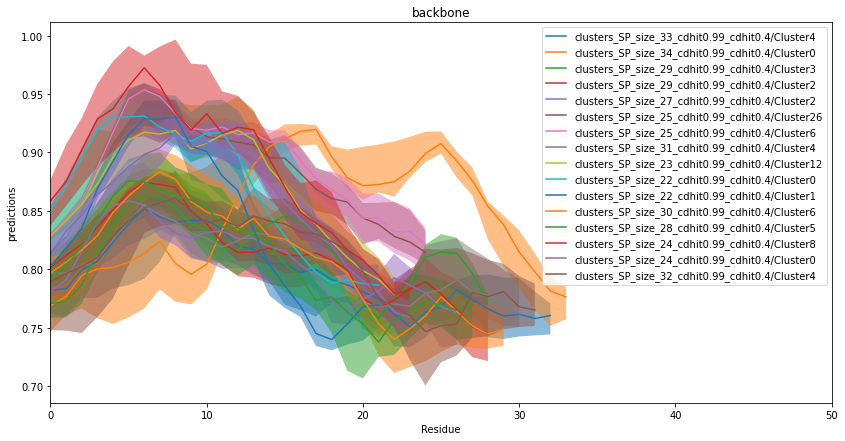

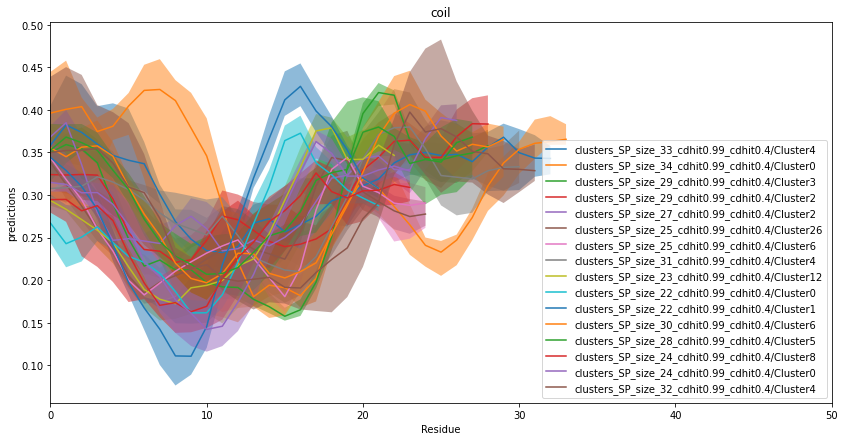

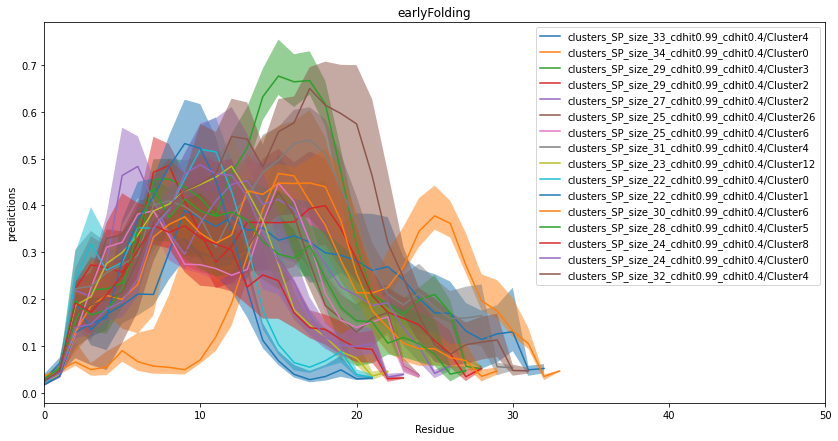

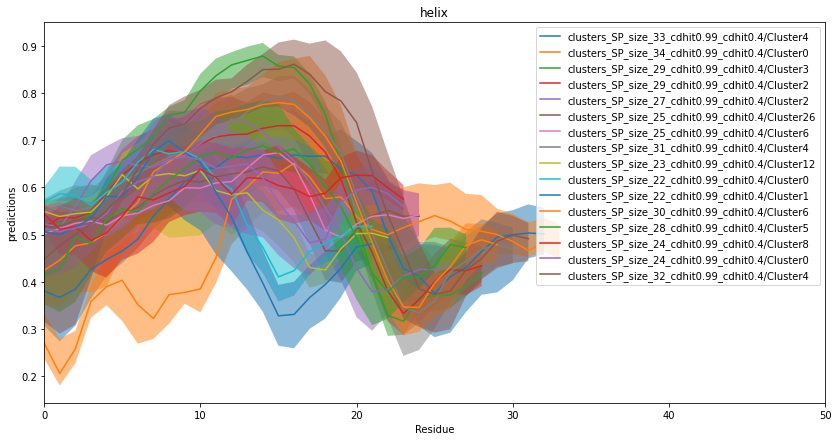

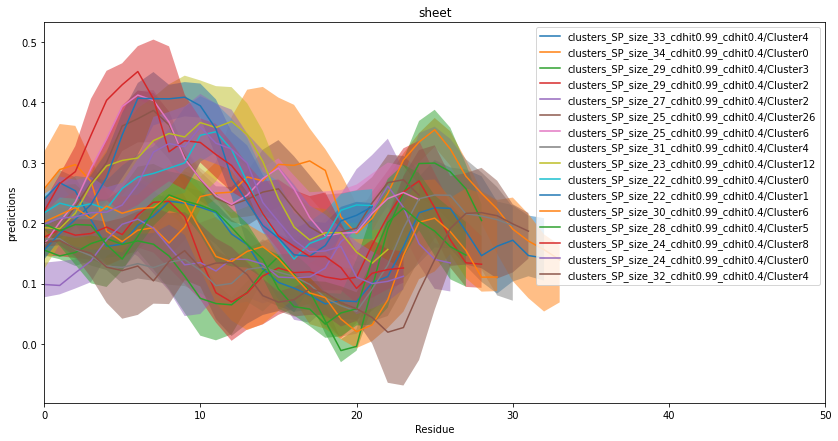

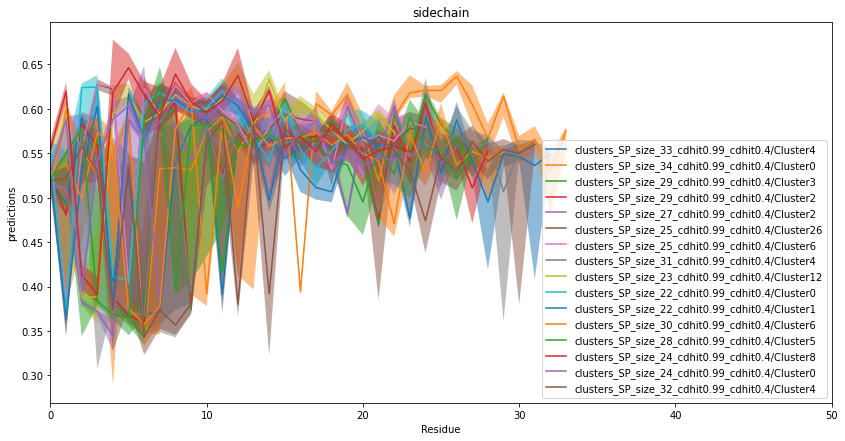

In [73]:
""" Visualise predictions """
DIR="spByLength/"
for FEATURE in ['backbone', 'coil', 'earlyFolding', 'helix', 'sheet', 'sidechain']:
    plt.figure(figsize=(14,7))
    plt.title(FEATURE)
    for SUBDIR in [F for F in os.listdir(DIR) if F.count("clusters")>0]:
        SUBDIR_PATH="{}{}/".format(DIR,SUBDIR)
        for PRED in [F for F in os.listdir(SUBDIR_PATH) if F.endswith(".pred")]:
            PRED_PATH="{}{}".format(SUBDIR_PATH,PRED)
            PRED_DIC=msaPredictions2Dic(PRED_PATH)
            PRED_ARRAY=msaPredictionsDic2Arrays(PRED_DIC)
            
            ARRAY = PRED_ARRAY[FEATURE]
            PERCENTILE25=np.nanpercentile(ARRAY,25,axis=0)
            MEDIAN=np.nanmedian(ARRAY,axis=0)
            PERCENTILE75=np.nanpercentile(ARRAY,75,axis=0)


            plt.fill_between(range(len(PERCENTILE25)),PERCENTILE25,PERCENTILE75, alpha=0.50)
            plt.plot(MEDIAN,label=PRED_PATH.split("/",1)[1].split("_EFoldMine")[0])
    plt.xlabel("Residue")
    plt.ylabel("predictions")
    plt.xlim((0,50))
    plt.legend()
    plt.show()

/home/jan/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/jan/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


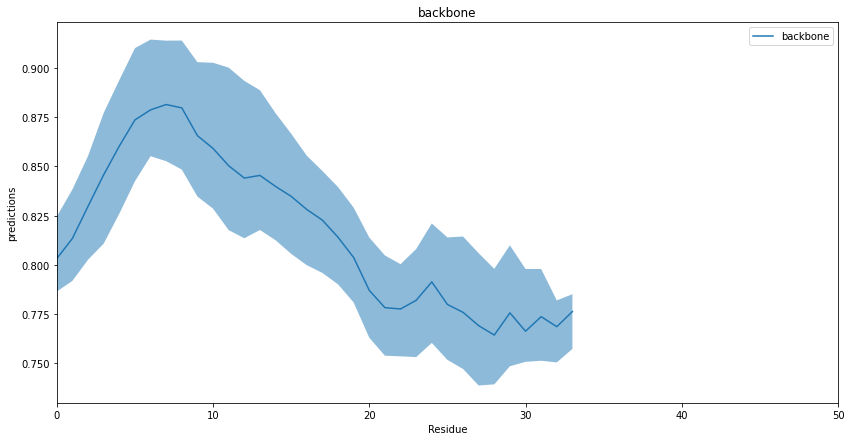

/home/jan/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/jan/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


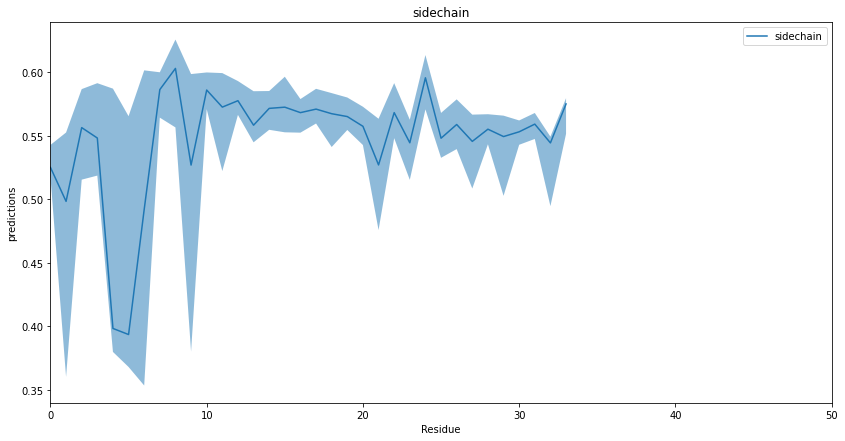

/home/jan/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/jan/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


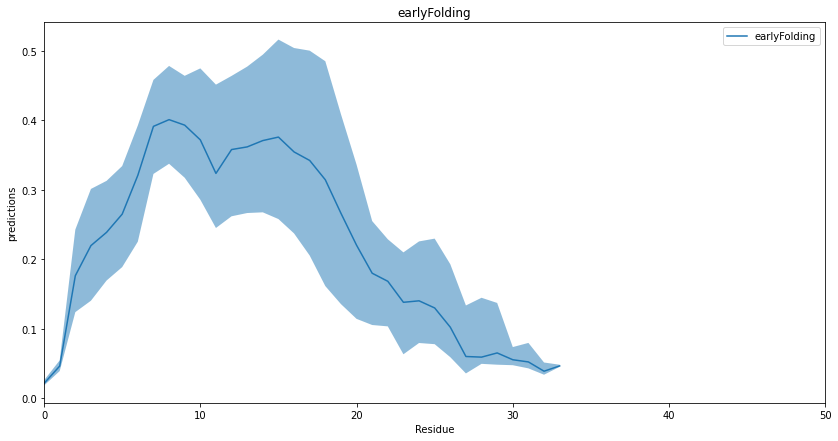

/home/jan/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/jan/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/jan/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/jan/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/jan/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/jan/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, 

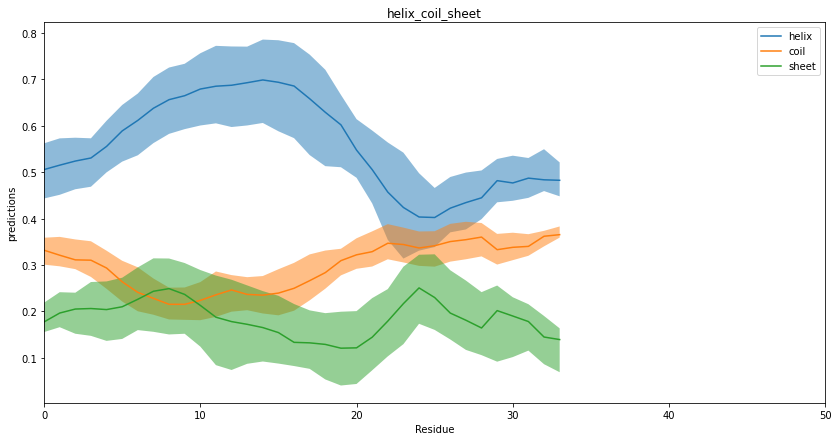

In [96]:
""" Combine all predictions and visualise"""
DIR="spByLength/"
for FEATURES in [['backbone'], ['sidechain'],['earlyFolding'], ['helix', 'coil','sheet']]:
    plt.figure(figsize=(14,7))
    plt.title("_".join(FEATURES))
    for FEATURE in FEATURES:
        ARRAY_CONCAT=np.zeros((0,50))
        for SUBDIR in [F for F in os.listdir(DIR) if F.count("clusters")>0]:
            SUBDIR_PATH="{}{}/".format(DIR,SUBDIR)
            for PRED in [F for F in os.listdir(SUBDIR_PATH) if F.endswith(".pred")]:
                PRED_PATH="{}{}".format(SUBDIR_PATH,PRED)
                PRED_DIC=msaPredictions2Dic(PRED_PATH)
                PRED_ARRAY=msaPredictionsDic2Arrays(PRED_DIC)

                ARRAY = PRED_ARRAY[FEATURE]
                ARRAY_TO_ADD = np.zeros((len(ARRAY),50))*float("nan")
                ARRAY_TO_ADD[:,:len(ARRAY[0])]=ARRAY
                ARRAY_CONCAT=np.append(ARRAY_CONCAT,ARRAY_TO_ADD,axis=0)

        PERCENTILE25=np.nanpercentile(ARRAY_CONCAT,25,axis=0)
        MEDIAN=np.nanmedian(ARRAY_CONCAT,axis=0)
        PERCENTILE75=np.nanpercentile(ARRAY_CONCAT,75,axis=0)
        plt.fill_between(range(len(PERCENTILE25)),PERCENTILE25,PERCENTILE75, alpha=0.50)
        plt.plot(MEDIAN,label=FEATURE)
    plt.xlabel("Residue")
    plt.ylabel("predictions")
    plt.xlim((0,50))
    plt.legend()
    plt.show()